# Modeling - Given these features, what model works best?

## Here you can actually test assumptions within 03_modeling.ipynb
#### These require the fitted model's residuals, i.e., predictions and fitted model, so they cannot be run until after fitting:
1. Linearity by residuals vs predicted plot.
2. Homoscedasticity with spread of residuals vs predicted.
3. Normality of errors with Q-Q plot of residuals.
4. Independence with residuals vs time/order.
5. Multicollinearity with VIF, condition number.
6. Influential points with Cook's distance.

In [1]:
# 3rd Party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# linear_regression_001
from linear_regression_001.data.loader import load_raw_data
from linear_regression_001.features.build_features import split_features_target, build_features, build_preprocessor, FEATURE_LIST
from linear_regression_001.utils.paths import INTERIM, PROCESSED, INFERENCE, PREDICTIONS, MODELS
from linear_regression_001.models import train_models, predict_features, evaluate_model

# Baseline Model
from sklearn.dummy import DummyRegressor

# Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score as r2

In [2]:
# ================================================================
# STEP 1: Setup Data
# ================================================================
# Load raw that is then cleaned on load
df = load_raw_data("insurance.csv")

# Split to X and y to build features
X, y = split_features_target(df)

# Build dataset and preprocessor
X_features_built = build_features(X,FEATURE_LIST)
df = pd.concat([X_features_built,y],axis=1)
preprocessor = build_preprocessor()

# split the train and test
X_train, X_test, y_train, y_test = train_test_split(X_features_built,y,test_size=0.2,random_state=42)


*normalized*
*missing checked*
*schema enforced*


In [3]:
# ================================================================
# STEP 2: Train Multiple Models
# ================================================================

# Dummy Regressor

baseline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])
baseline.fit(X_train,y_train)


# Linear Regression
lr = Pipeline([
    ("preprocessor",preprocessor),
    ("model",LinearRegression())
])
lr.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [4]:
# Ridge
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge())
])
param_grid = {
    'model__alpha': np.logspace(-4, 3, 20)
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv = 5,
    scoring = "neg_mean_squared_error"
)

grid.fit(X_train, y_train)

print("Best alpha: ", grid.best_params_)
print("Best CV score: ", -grid.best_score_)

best_ridge = grid.best_estimator_

joblib.dump(best_ridge, MODELS / "ridge.pkl")

Best alpha:  {'model__alpha': np.float64(0.0001)}
Best CV score:  24313461.368943825


['/home/kenchan/projects/linear_regression/linear_regression_001/linear_regression_001/models/saved_models/ridge.pkl']

In [5]:
# Lasso

pipeline = Pipeline([
    ("preprocessor",preprocessor),
    ("model", Lasso(max_iter=10000))
])

param_grid = {
    'model__alpha':np.logspace(-4, 1, 20)
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv = 5,
    scoring = "neg_mean_squared_error"
)

grid.fit(X_train, y_train)

print("Best alpha: ", grid.best_params_)
print("Best CV Score: ", -grid.best_score_)

best_lasso = grid.best_estimator_

joblib.dump(best_lasso, MODELS / "lasso.pkl")

Best alpha:  {'model__alpha': np.float64(0.07847599703514607)}
Best CV Score:  24313459.970700447


['/home/kenchan/projects/linear_regression/linear_regression_001/linear_regression_001/models/saved_models/lasso.pkl']

In [6]:
# ElasticNet

pipeline = Pipeline([
    ("preprocessor",preprocessor),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    'model__alpha': np.logspace(-4, 1, 10),
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 1]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error'
)

grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print("Best CV score: ", -grid.best_score_)

best_elastic = grid.best_estimator_

joblib.dump(best_elastic, MODELS / "elastic_net.pkl")

Best params:  {'model__alpha': np.float64(0.05994842503189409), 'model__l1_ratio': 1}
Best CV score:  24313459.896045472


['/home/kenchan/projects/linear_regression/linear_regression_001/linear_regression_001/models/saved_models/elastic_net.pkl']

In [7]:
# ================================================================
# STEP 3: Evaluate Models
# ================================================================
# Group models
models = {
    'baseline': baseline,
    'lin_reg': lr,
    'ridge': best_ridge,
    'lasso': best_lasso,
    'elastic_net': best_elastic
}

# Initialize results
results = []

# Cross Val Score for Models
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'r2')
    results.append({
        "model": name,
        "mean_score": scores.mean(),
        "std": scores.std()
    })

# Output as DataFrame to see the Best Model
results_df = pd.DataFrame(results).sort_values(by=["mean_score","std"],ascending=[False,True])
results_df

,model,mean_score,std
2,ridge,0.827989,0.045171
1,lin_reg,0.827988,0.045171
4,elastic_net,0.827988,0.045173
3,lasso,0.827988,0.045173
0,baseline,-0.004796,0.005035


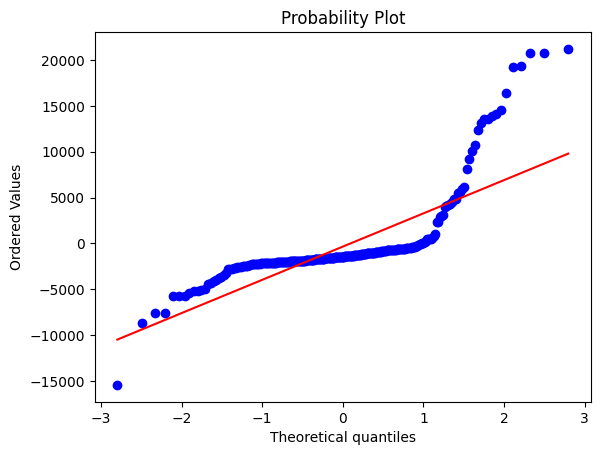

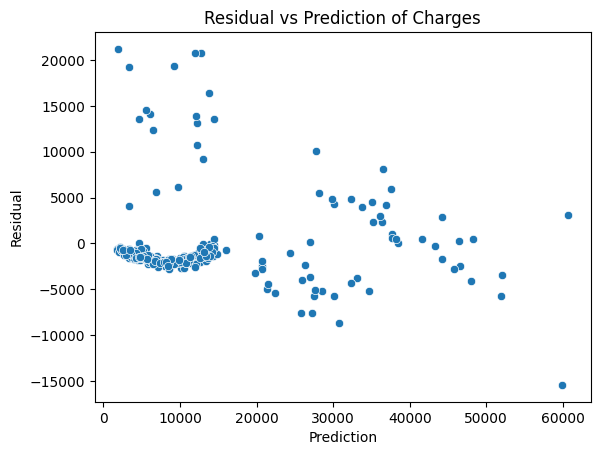

{'metrics': {'rmse': np.float64(4573.807686290385),
  'mae': 2756.898659517957,
  'r2': 0.8652503208873077,
  'mape': 29.24770582699016,
  'adjusted_r2': 0.8616224449111968},
 'baseline_comparison': {'baseline_rmse': np.float64(12465.610441715768),
  'model_rmse': np.float64(4573.807686290385),
  'improvement_percent': np.float64(-63.30859441119478),
  'beats_baseline': np.True_},
 'residual_analysis': {'mean_residual': np.float64(-342.37261123381757),
  'std_residual': np.float64(4560.975525723193),
  'residual_skewness': np.float64(2.643628716854398),
  'residual_kurtosis': np.float64(9.051494190997499),
  'max_overestimation': np.float64(-15418.306359906339),
  'max_underestimation': np.float64(21208.549780449517),
  'residuals_within_1std': np.float64(86.94029850746269)},
 'durbin_watson': {'durbin_watson': '2.15 => Errors are not autocorrelated.'}}

In [8]:
# Linear Regression
evaluate_model(MODELS / "linear_regression.pkl", INTERIM / "test.csv", MODELS / "baseline.pkl")

{'metrics': {'rmse': np.float64(4573.805255024336),
  'mae': 2756.900310597436,
  'r2': 0.8652504641431048,
  'mape': 29.24770738629884,
  'adjusted_r2': 0.8616225920238807},
 'baseline_comparison': {'baseline_rmse': np.float64(12465.610441715768),
  'model_rmse': np.float64(4573.805255024336),
  'improvement_percent': np.float64(-63.308613914981315),
  'beats_baseline': np.True_},
 'residual_analysis': {'mean_residual': np.float64(-342.3715010941844),
  'std_residual': np.float64(4560.973170950115),
  'residual_skewness': np.float64(2.643628168775114),
  'residual_kurtosis': np.float64(9.051435957899253),
  'max_overestimation': np.float64(-15418.087431014479),
  'max_underestimation': np.float64(21208.538724900616),
  'residuals_within_1std': np.float64(86.94029850746269)},
 'durbin_watson': {'durbin_watson': '2.15 => Errors are not autocorrelated.'}}

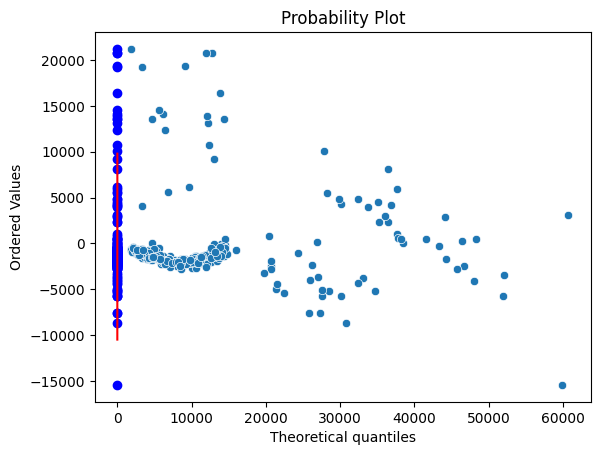

In [9]:
# Ridge
evaluate_model(MODELS / "ridge.pkl", INTERIM / "test.csv", MODELS / "baseline.pkl")

{'metrics': {'rmse': np.float64(4573.726840474379),
  'mae': 2757.031163700371,
  'r2': 0.8652550844682152,
  'mape': 29.250847514581608,
  'adjusted_r2': 0.8616273367423595},
 'baseline_comparison': {'baseline_rmse': np.float64(12465.610441715768),
  'model_rmse': np.float64(4573.726840474379),
  'improvement_percent': np.float64(-63.30924296199287),
  'beats_baseline': np.True_},
 'residual_analysis': {'mean_residual': np.float64(-342.3560877039321),
  'std_residual': np.float64(4560.895692787526),
  'residual_skewness': np.float64(2.6435796450837303),
  'residual_kurtosis': np.float64(9.048821813858876),
  'max_overestimation': np.float64(-15409.217945194403),
  'max_underestimation': np.float64(21207.545849901842),
  'residuals_within_1std': np.float64(86.94029850746269)},
 'durbin_watson': {'durbin_watson': '2.15 => Errors are not autocorrelated.'}}

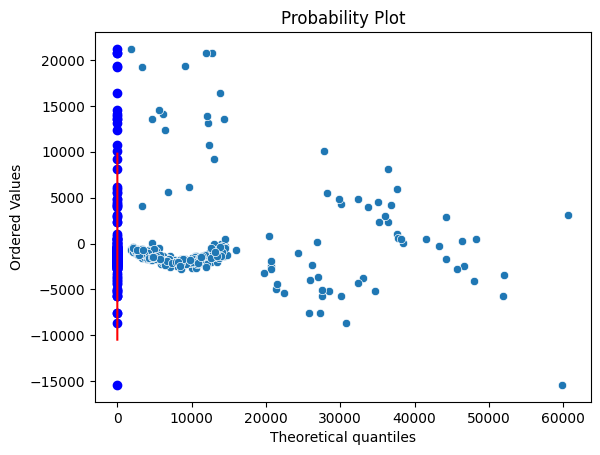

In [10]:
# Lasso
evaluate_model(MODELS / "lasso.pkl", INTERIM / "test.csv", MODELS / "baseline.pkl")

{'metrics': {'rmse': np.float64(4573.745881154683),
  'mae': 2756.999874980938,
  'r2': 0.8652539625646608,
  'mape': 29.250105716245667,
  'adjusted_r2': 0.8616261846337094},
 'baseline_comparison': {'baseline_rmse': np.float64(12465.610441715768),
  'model_rmse': np.float64(4573.745881154683),
  'improvement_percent': np.float64(-63.30909021632195),
  'beats_baseline': np.True_},
 'residual_analysis': {'mean_residual': np.float64(-342.3599907081927),
  'std_residual': np.float64(4560.914494061659),
  'residual_skewness': np.float64(2.6435913382990357),
  'residual_kurtosis': np.float64(9.049453016366426),
  'max_overestimation': np.float64(-15411.364056785584),
  'max_underestimation': np.float64(21207.78289489103),
  'residuals_within_1std': np.float64(86.94029850746269)},
 'durbin_watson': {'durbin_watson': '2.15 => Errors are not autocorrelated.'}}

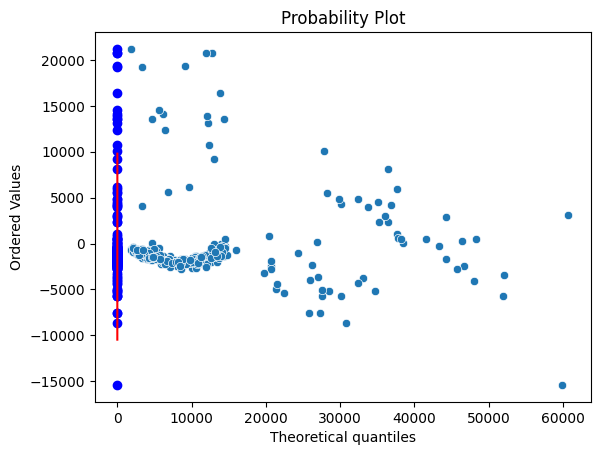

In [11]:
# ElasticNet
evaluate_model(MODELS / "elastic_net.pkl", INTERIM / "test.csv", MODELS / "baseline.pkl")

In [54]:
# Feature importance
coef = best_ridge.named_steps['model'].coef_
features = best_ridge.named_steps['preprocessor'].get_feature_names_out()

importance = pd.Series(coef, index=features).sort_values()
importance


cat__smoker_yes         -21206.488011
cat__region_southwest    -1233.420622
cat__region_southeast     -967.476553
cat__region_northwest     -631.412333
cat__sex_male             -525.226735
num__bmi                   122.343526
num__children              563.529844
num__age                  3705.215539
num__bmi_smoker          18608.561650
dtype: float64

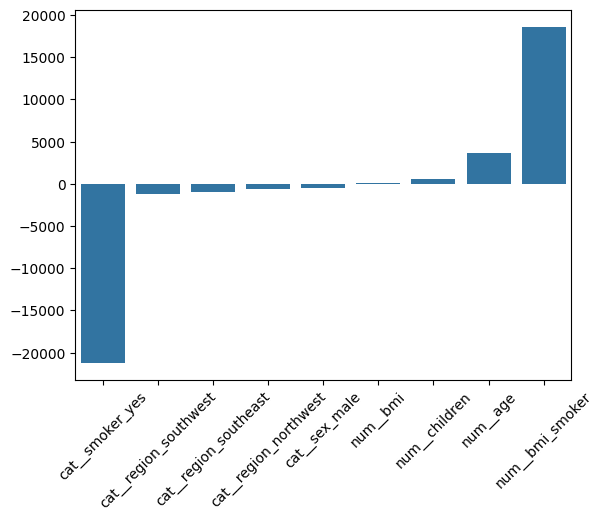

In [66]:
sns.barplot(importance)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Final model train

In [ ]:
# ================================================================
# STEP 4: Save final model
# ================================================================
results_df

,model,mean_score,std
2,ridge,0.827989,0.045171
1,lin_reg,0.827988,0.045171
4,elastic_net,0.827988,0.045173
3,lasso,0.827988,0.045173
0,baseline,-0.004796,0.005035


In [67]:
joblib.dump(best_lasso,MODELS / "best_model.pkl")

['/home/kenchan/projects/linear_regression/linear_regression_001/linear_regression_001/models/saved_models/best_model.pkl']